**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Introducción al Aprendizaje profundo**

*Edición 2023*

----

# Trabajo práctico entregable

Dado el dataset que busca [detectar si una oración es sarcástica o no](https://www.kaggle.com/datasets/saurabhbagchi/sarcasm-detection-through-nlp?select=Sarcasm_Headlines_Dataset.json).

## Ejercicio 3 - Implementar modelo con ajuste de hiperparámetros e interpretar resultados

En una siguiente instancia realizar una búsqueda de hiperparámetros buscando mejorar el baseline.
Traten de centrarse en probar 2, como mucho 3, hiperparámetros y ver los cambios con base a esos
hiperparámetros porque las pruebas se hacen infinitas. La idea es que prueben:

* Diferentes tamaños de épocas.
* Tamaño de batch.
* Cantidad de capas lstm.
* Valor de dropout, etc. 

Mostrar e Interpretar los resultados.

----

### Imports y lectura de datasets

In [1]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Lectura de los Datasets

In [3]:
clean_df = pd.read_csv('./datasets/clean_data.csv')
vec_df = pd.read_csv('./datasets/vec_data.zip')
clean_df.shape, vec_df.shape

((26709, 3), (26709, 300))

In [4]:
clean_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sue secret black co...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,roseanne revival catch thorny political mood w...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom start fear son web series closest thing gr...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner want wife listen come alternative debt...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wish snape happy birthday magical way,0


In [5]:
vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.063707,0.048075,-0.035156,0.015344,-0.040704,0.029650,-0.108602,0.064033,0.079563,0.067071,...,0.093753,0.098985,-0.086890,0.072653,0.014648,-0.033034,0.081028,-0.063841,0.092285,0.013021
1,0.110565,0.088832,-0.036540,0.136963,-0.152344,-0.055520,-0.029580,0.003139,0.119420,0.089905,...,-0.103620,-0.045201,-0.051130,-0.059675,0.010145,0.024798,-0.093523,-0.024693,0.083793,0.102295
2,0.045600,-0.048794,0.060248,0.087233,-0.013570,0.068970,0.032766,-0.136597,0.160970,0.018907,...,-0.096569,0.052219,-0.179538,-0.142578,-0.029181,-0.056970,-0.084283,-0.084378,0.003689,0.014065
3,0.040670,-0.038706,0.055664,0.105265,-0.152262,0.120453,0.107564,-0.055745,0.054810,0.019618,...,-0.166016,0.091024,-0.085571,-0.017415,-0.080399,0.046712,0.049357,-0.097941,0.040263,0.005035
4,0.069037,0.069434,0.017949,0.150391,0.018481,-0.097095,0.144531,-0.128174,0.133057,0.035742,...,0.006201,0.057874,-0.129321,-0.053760,0.007910,-0.016357,-0.066657,0.001245,-0.018164,-0.040430


### División del dataset

Dividimos aleatoriamente los datos en 80% para ***entrenamiento*** y 20% para ***test***. Del 20% de los datasets de *test* los dividiremos en partes iguales para ***test*** y ***validación***. 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vec_df.values, clean_df.is_sarcastic.values,
                                                    train_size=0.8, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21367, 300), (5342, 300), (21367,), (5342,))

Una vez separados los datasets, es necesario convertir los datos en ***tensores*** de *PyTorch*.

In [7]:
# Creamos los tensores desde los array de numpy
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)


X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [8]:
# Creamos los Dataset de tensores
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Definimos el batch size en 50
batch_size = 50

# Creamos los DataLoader desde los Dataset de tensores
# Mezclamos los datos para un mejor entrenamiento
# Activamos el drop_last para descartar la última porción
# de datos que sea menor al batch_size
train_loader = DataLoader(train_data, shuffle=True, 
                          batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True,
                          batch_size=batch_size, drop_last=True)

### Planteo del modelo

En esta primera aproximación se definirá un modelo básico ***LSTM***, el cual entrenaremos, evaluaremos y utilizaremos para hacer predicciones.

In [9]:
class BaselineModel(nn.Module):
    def __init__(self,
                 layers_number,     # Definimos la cantidad de capas LSTM
                 vocab_size,        # Tamaño de la entrada (input_size)
                 hidden_dim,        # Cantidad de neuronas que va a tener cada capa
                 embedding_dim,     # Dimensión de los vectores
                 output_dim,        # Cantidad de clases a predecir
                 dropout=0.5):

        super(BaselineModel, self).__init__()

        self.layers_number = layers_number
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Embedding and LSTM layers
        # Dimension de los vectores de embeddings para representar las palabras
        # Es una matriz que tiene tantas filas como palabras y tantas columnas como la dimension
        # del vector que definimos
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # La capa lstm toma como entrada los embeddings
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_dim,    # Representa la cantidad de features en el estado oculto
                            num_layers=layers_number,       # Número de capas recurrentes
                            batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3) # Este dropout es para todas las layers a diferencia de las otras redes.

        # Linear and sigmoid layer
        self.lineal = nn.Linear(self.hidden_dim, output_dim) # Transforma las LSTM en un vector de dimension igual al número de clases
        self.sigmoid = nn.Sigmoid()

    def forward(self,x,hidden):
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: BATCH x SENQUENCE_LENGHT x FEATURES   since batch = True (Features es la cantidad total de palabras)
        #print(embeds.shape)  #[X, Y,Z]
        lstm_out, hidden = self.lstm(embeds, hidden) # Obtenemos las celdas de salidas y un nuevo estado oculto

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # Redimensiona para tener la forma (batch_size*seq_len, hidden_dim) -> tensor de 2 dimensiones

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.lineal(out)

        # sigmoid function
        sig_out = self.sigmoid(out)

        #Redimensionamos para tener dimension (batch_size, -1),
        #es decir para obtener las predicciones finales de la red LSTM de cada lote
        sig_out = sig_out.view(batch_size, -1)


        sig_out = sig_out[:, -1] # Selecciona la ultima columna de la variable sig_out que contiene, en general, los resultados de la capa lineal

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.layers_number,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.layers_number,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [10]:
# Definimos una semilla para hacer que el entrenamiento sea reproducible
torch.manual_seed(0)

# Definimos los parámetros del modelo
layers_numbers = [1, 2, 3]
vocab_size = 100000
embedding_dim = 300
output_dim = 1
hidden_dim = 256

# Función loss y optimizadores
learning_rates = [0.001, 0.0001, 0.00001]
criterion = nn.BCELoss()
optimizers = {
    'Adaptative Gradient Algorithm': optim.Adagrad,
    'Root Mean Square Propagation': optim.RMSprop,
    'Adaptive Moment Estimation': optim.Adam
}
clip = 5            # Clipping, evitar una explosion del gradiente
EPOCHS = 30         # Cantidad de épocas a entrenar
valid_loss_min = np.Inf

In [11]:
# Función para predecir la precisión
def acc(pred, label):
    # Nos aseguramos que tanto pred como label tengan las mismas dimensiones
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item() # Cantidad de predicciones correctas

### Entrenamiento del modelo base



In [ ]:
from itertools import product

# Guarda el mejor modelo y sus resultados
best_model = None
best_epoch_tr_loss = []
best_epoch_vl_loss = []
best_epoch_tr_acc = []
best_epoch_vl_acc = []

# Itera sobre todas las combinaciones posibles de modelos y hiperparámetros
for layers_number, learning_rate, optimizer in product(layers_numbers, learning_rates, optimizers.values()):
    # Instanciamos la clase
    model = BaselineModel(layers_number, vocab_size, hidden_dim, embedding_dim, output_dim, dropout=0.5)
    # Trasladamos el modelo al device seleccionado
    model.to(device)
    
    current_optimizer = optimizer(model.parameters(), lr=learning_rate)
    
    
    # Creamos los arreglos para las métricas:
    epoch_tr_loss = []
    epoch_vl_loss = []
    
    epoch_tr_acc = []
    epoch_vl_acc = []
    
    for epoch in trange(EPOCHS):
        train_losses = []
        train_acc = 0.0
        model.train()
    
        # initialize hidden state
        # Establecemos el estado inicial en cero
        hidden = model.init_hidden(batch_size)
    
        # Dado que el dataset tiene x datos y pusimos un batch de y
        # vamos a hacer n pasos de entrenamiento
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device).long()
            labels = labels.to(device)
    
            # Creamos nuevas variables para el estado oculto,
            # de otra manera propagariamos a lo largo de toda la historia de entrenamiento teniendo problemas del explosion del gradiente.
            # El estado oculto se actualiza en cada paso de tiempo
            # Con la linea siguiente "devinculamos" el estado oculto de cualquier calculo anterior
            # y solo extraemos sus valores copiandolos con each.data
            hidden = tuple([each.data for each in hidden])
    
            model.zero_grad()
            output,hidden = model(inputs,hidden) #Realizamos un paso hacia adelante
    
            # Calculamos la loss y hacemos el backpropagation
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
    
            train_losses.append(loss.item())
    
            # calculating accuracy
            accuracy = acc(output,labels)
            train_acc += accuracy
    
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            # Limita la norma de los gradientes al valor especificado en clip
            # model.parameters() es una lista de los parámetros del modelo,
            # que son tensores en los que se almacenan los gradientes después de realizar la retropropagación del error.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            current_optimizer.step()
    
        val_h = model.init_hidden(batch_size)
        val_losses = []
        val_acc = 0.0
        model.eval()
        for inputs, labels in test_loader:
            val_h = tuple([each.data for each in val_h])
    
            inputs =  inputs.to(device).long()
            labels = labels.to(device)
    
    
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())
    
    
            val_losses.append(val_loss.item())
    
            accuracy = acc(output,labels)
            val_acc += accuracy
    
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
    
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(test_loader.dataset)
    
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
    
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
    
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    
        if epoch_val_loss <= valid_loss_min:
            best_epoch_tr_loss = epoch_tr_loss
            best_epoch_vl_loss = epoch_vl_loss
            best_epoch_tr_acc = epoch_tr_acc
            best_epoch_vl_acc = epoch_vl_acc
            torch.save(model.state_dict(), './models/best_model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')

### Análisis de métricas

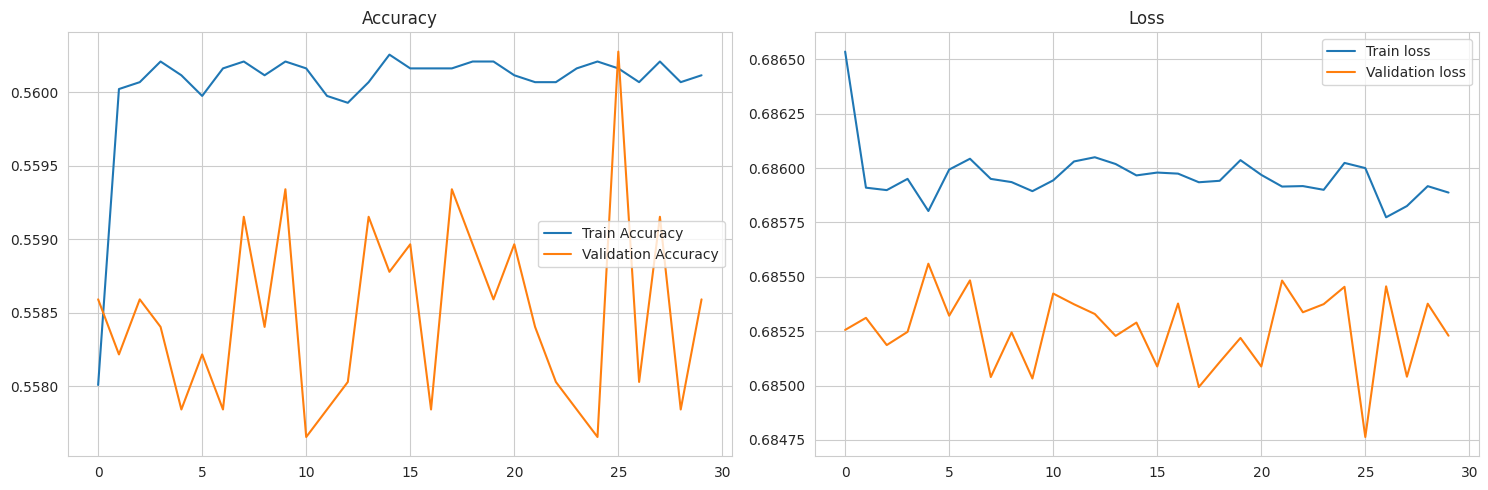

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
axes[0].title.set_text('Accuracy')
sns.lineplot(ax=axes[0], data=best_epoch_tr_acc, label='Train Accuracy')
sns.lineplot(ax=axes[0], data=best_epoch_vl_acc, label='Validation Accuracy')

axes[1].title.set_text('Loss')
sns.lineplot(ax=axes[1], data=best_epoch_tr_loss, label='Train loss')
sns.lineplot(ax=axes[1], data=best_epoch_vl_loss, label='Validation loss')

plt.tight_layout()

En ambas gráficas, al igual que para el modelo base, podemos observar que las métricas de validación son mucho más inestables que las de entrenamiento, estabilizándose en ambos casos alrededor de un valor luego de la época 1.

Los resultados obtenidos no reflejaron mejoras significativas en términos de **accuracy** y **loss** en comparación con el modelo baseline. Este hallazgo sugiere varias posibles interpretaciones.

Es posible que el conjunto de datos utilizado no contenga patrones lo suficientemente distintivos para permitir que el modelo distinga de manera efectiva los titulares sarcásticos y no sarcásticos, que el preprocesamiento aplicado no haya sido el correcto para los datos y termine perjudicando el aprendizaje de la red neuronal, o bien, al cambiar la arquitectura del modelo y probar diferentes configuraciones, podríamos haber complicado el procedimiento de aprendizaje y terminado con un ajuste no tan bueno. 

En conclusión, aunque los resultados no fueron los esperados, este estudio proporciona valiosas lecciones sobre la complejidad inherente al abordar problemas de clasificación de sarcasmo en titulares. En futuros trabajos se podrían considerar la exploración de técnicas de preprocesamiento diferentes o probar el uso de arquitecturas de modelos alternativas para mejorar la capacidad de captura de características distintivas.